# Motivation for Topic

The goal of this analysis is to understand whether quarterbacks who scramble and/or run have shorter careers in general than quarterbacks who don't. A “scramble” is when the quarterback gets the football and then is forced to run with it, as opposed to throwing it immediately (or taking a sack). This exposes them to more dangerous plays, as they subject themselves to more tackles and hard hits from the opposing team. I hypothesize that quarterbacks who rush more will have shorter careers than those who rush less, because it opens them up to more tackles, big hits and injuries.

I first use exploratory data analysis to draw a holistic picture of the rushing careers of quarterbacks since the first Super Bowl (a cutoff I explain further down). This gives an initial idea of how rushing quarterbacks fare in their careers. I then perform a regression analysis to identify outliers and see whether their careers were impacted by their rushing.

# Package and data imports and setup

In [38]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
from scipy.stats import f, t
from itertools import compress

Function used throughout to print titles of sections:

In [2]:
def title_print(text):
    '''
    Used throughout to print section titles
    '''
    print()
    print('#' * (len(text) + 4))
    print('|', text, '|')
    print('#' * (len(text) + 4))

# Explanation of Data

I scraped the data for this analysis from [The Football Database](https://www.footballdb.com/). Below I read in the dataset and present the first 10 lines. I also organize the data in order of total yards per quarterback.

In [3]:
df = pd.read_csv('qb_rushing.csv')

In [4]:
df = df.sort_values('player_rank').reset_index(drop = True)
print(df.head(10))

   player_rank              player  first_year  last_year         draft team  \
0            1        Michael Vick        2001       2015           1-1  TOT   
1            2  Randall Cunningham        1985       2001          2-37  TOT   
2            3          Cam Newton        2011       2019           1-1  CAR   
3            4           Tom Matte        1961       1972   1-7 5-37AFL  CLT   
4            5         Steve Young        1985       1999           1-1  TOT   
5            6      Russell Wilson        2012       2019          3-75  SEA   
6            7      Fran Tarkenton        1961       1978  3-29 5-34AFL  TOT   
7            8        Steve McNair        1995       2007           1-3  TOT   
8            9      Charley Trippi        1947       1955           1-1  CRD   
9           10      Donovan McNabb        1999       2011           1-2  TOT   

  league  games_played  games_started  rushing_attempts  total_yards  \
0    NFL         143.0          115.0          

In [5]:
print('Total QBs: {}'.format(df.shape[0]))

Total QBs: 985


There are 985 quarterbacks (rows) in this dataset. However, as in any sport, the rules and strategy of the game has changed over the years. In order to keep the analysis consistent, I choose to look only at quarterbacks who have been in the league since the first Super Bowl, i.e. the 1966-1967 season. I also remove any quarterbacks who played less than one full year and started in 10 or less games. This is an attempt to remove any anomolies, such as a quarterback who was only briefly in the league but had several big plays, or a backup quarterback who was in the league for many years.

In [37]:
df = df[(df['first_year'] < df['last_year']) &
        (df['games_started'] >= 10) &
        (df['first_year'] >= 1966)]
print('QBs who played >1 year, started 10+ games, since 1966-67 season: {}'\
      .format(df.shape[0]))

QBs who played >1 year, started 10+ games, since 1966-67 season: 320


# Descriptive Statistics

The following five categories (`games_played`, `games_started`, `rushing_attempts`, `yards_per_attempt`, `total_yards`) are the quantitative statistics associated with each quarterback. I look at the descriptive statistics of those categories here to get an understanding of the spread of the data. The large standard deviations imply there is significant spread among the data.

In [33]:
categories = ['games_played', 'games_started', 'rushing_attempts',
              'yards_per_attempt', 'total_yards']
print()
print(df[categories].describe())


       games_played  games_started  rushing_attempts  yards_per_attempt  \
count    320.000000     320.000000        320.000000         320.000000   
mean      87.793750      65.984375        183.625000           3.475625   
std       59.252194      58.508658        165.786555           1.560323   
min       12.000000      10.000000         10.000000          -0.030000   
25%       38.000000      20.000000         59.750000           2.330000   
50%       73.000000      44.000000        129.500000           3.470000   
75%      125.000000      97.250000        248.000000           4.595000   
max      302.000000     298.000000        934.000000           7.250000   

       total_yards  
count   320.000000  
mean    723.209375  
std     869.308396  
min      -1.000000  
25%     159.750000  
50%     443.000000  
75%     959.250000  
max    6109.000000  


# Exploratory Data Analysis

## Career Games Played

The following distribution plot shows the spread of the number of games played per quarterback. There is an obvious right skew as there is no upper limit to the number of games a quarterback can play, but there is a lower limit. Additionally, with each game played there is an increasing chance that it will be the last game played. Therefore, the median number of games played is almost 15 less than the mean and will be a more telling statistic to use for an average than the mean.

Note that the following 4 plots are distribution plots, which show a histogram with a kernal density estimate overlaid. The values on the y-axis pertain to the kernal density estimate.

In [8]:
games_max = int(max(df['games_played']))
games_mean = round(df['games_played'].mean(), 1)
games_median = df['games_played'].median()

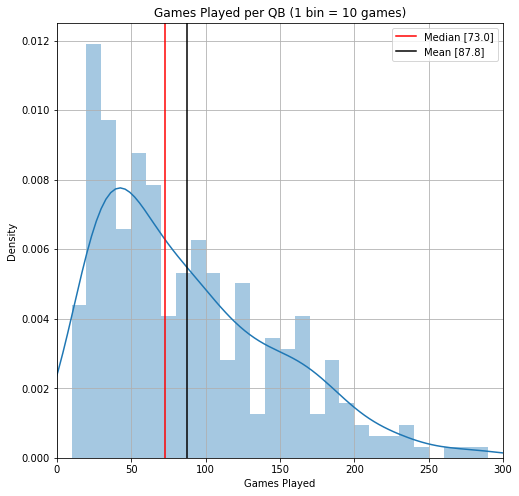

In [9]:
plt.figure(figsize = (8, 8))
sns.distplot(df['games_played'], [i for i in range(0, games_max, 10)])
plt.axvline(games_median,
            color = 'red',
            label = 'Median [{}]'.format(games_median))
plt.axvline(games_mean,
            color = 'black',
            label = 'Mean [{}]'.format(games_mean))
plt.title('Games Played per QB (1 bin = 10 games)')
plt.xlabel('Games Played')
plt.ylabel('Density')
plt.xlim(0, 10 * math.floor(games_max/10))
plt.grid(which = 'major')
plt.legend(loc = 'best')
plt.show()

## Career Rushing Attempts

There is an even more prominent right skew when looking at the number of rushing attempts per quarterback, with the median being 54 attempts lower than the mean (almost 30%). Again, looking at the median as opposed to the mean here will be more informative.

In [10]:
attempts_max = int(max(df['rushing_attempts']))
attempts_mean = round(df['rushing_attempts'].mean(), 1)
attempts_median = round(df['rushing_attempts'].median(), 1)

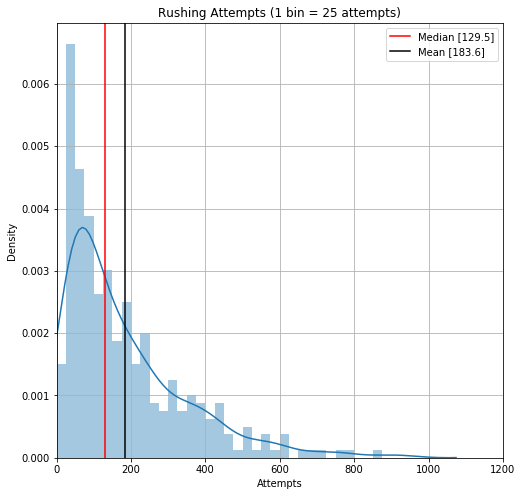

In [11]:
plt.figure(figsize = (8, 8))
sns.distplot(df['rushing_attempts'], [i for i in range(0, attempts_max, 25)])
plt.axvline(attempts_median,
            color = 'red',
            label = 'Median [{}]'.format(attempts_median))
plt.axvline(attempts_mean,
            color = 'black',
            label = 'Mean [{}]'.format(attempts_mean))
plt.xlim(0, 1200)
plt.title('Rushing Attempts (1 bin = 25 attempts)')
plt.xlabel('Attempts')
plt.ylabel('Density')
plt.grid(which = 'major')
plt.legend(loc = 'best')
plt.show()

## Career Rushing Yards

Lastly, looking at the total yards per quarterback shows the same right skew, with a rather long tail. I think this plot is somewhat telling as one can see that the *vast* majority of quarterbacks only run with necessary (median less than 450 total career yards), but there are some who use their rushing ability to their advantage.

In [12]:
tot_yards_max = int(max(df['total_yards']))
tot_yards_mean = round(df['total_yards'].mean(), 1)
tot_yards_median = round(df['total_yards'].median(), 1)

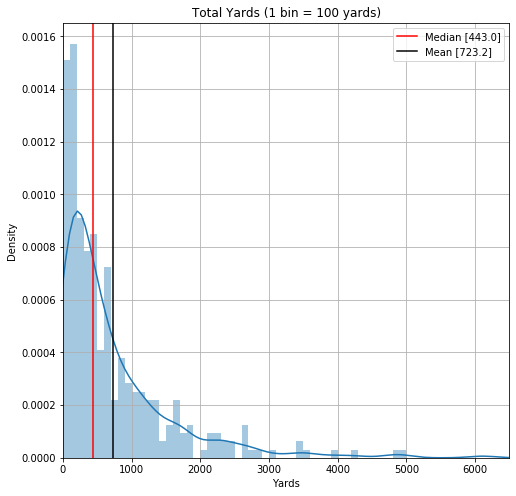

In [13]:
plt.figure(figsize = (8, 8))
sns.distplot(df['total_yards'], [i for i in range(0, tot_yards_max, 100)])
plt.axvline(tot_yards_median,
            color = 'red',
            label = 'Median [{}]'.format(tot_yards_median))
plt.axvline(tot_yards_mean,
            color = 'black',
            label = 'Mean [{}]'.format(tot_yards_mean))
plt.xlim(0, 6500)
plt.title('Total Yards (1 bin = 100 yards)')
plt.xlabel('Yards')
plt.ylabel('Density')
plt.grid(which = 'major')
plt.legend(loc = 'best')
plt.show()

## Average Rushing Yards per Attempt

I next look at the spread of yards per attempt for all quarterbacks. Yards per attempt is a summary statistic which simply divides the total yards rushed by the number of attempts over the course of a career. This is a near-perfect normal distribution, with the mean and median both falling at 3.5 yards per attempt.

In [14]:
yards_max = int(max(df['yards_per_attempt']))
yards_mean = round(df['yards_per_attempt'].mean(), 1)
yards_median = round(df['yards_per_attempt'].median(), 1)

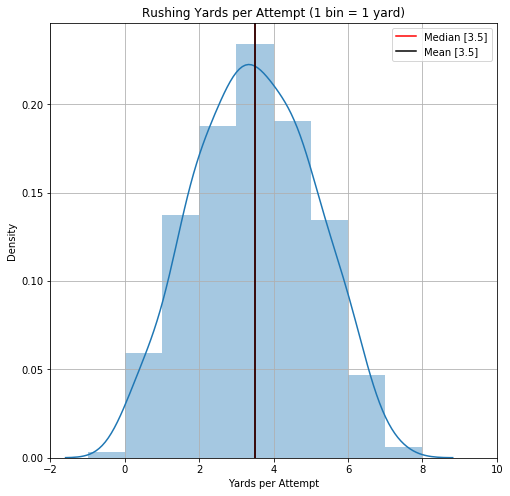

In [15]:
plt.figure(figsize = (8, 8))
sns.distplot(df['yards_per_attempt'], bins = [i for i in range(-2, 11)])
plt.axvline(yards_median,
            color = 'red',
            label = 'Median [{}]'.format(yards_median))
plt.axvline(yards_mean,
            color = 'black',
            label = 'Mean [{}]'.format(yards_mean))
plt.xlim(-2, 10)
plt.title('Rushing Yards per Attempt (1 bin = 1 yard)')
plt.xlabel('Yards per Attempt')
plt.ylabel('Density')
plt.grid(which = 'major')
plt.legend(loc = 'best')
plt.show()

## Games Played for Top and Bottom 25% of Rushers

The last thing I look at before I move into the linear regression model is the mean number of games played per quarterback for the top 25% and bottom 25%, based on yards per attempt. I am using yards per attempt as a proxy for how "good" a quarterback is at rushing over the course of their career. A quarterback who plays for longer will have more opportunities to attempt a rush and therefore accumulate more total yards, so I can't draw any useful information from looking at these statistics independently here.

In [34]:
quantiles = [0.25, 0.5, 0.75]
gp_quant = np.quantile(df['games_played'], quantiles)
ra_quant = np.quantile(df['rushing_attempts'], quantiles)
ypa_quant = np.nanquantile(df['yards_per_attempt'], quantiles)

ypa_top25 = df[df['yards_per_attempt'] > ypa_quant[2]]
ypa_bot25 = df[df['yards_per_attempt'] < ypa_quant[0]]
ypa_top25_mean_games = round(ypa_top25['games_played'].mean(), 1)
ypa_top25_median_games = round(ypa_top25['games_played'].median(), 1)
ypa_bot25_mean_games = round(ypa_bot25['games_played'].mean(), 1)
ypa_bot25_median_games = round(ypa_bot25['games_played'].median(), 1)

print('Mean games played, top 25% of QBs [count: {}] based on yards per '
      'attempt: \n---> {} <---'.format(ypa_top25.shape[0],
                                       ypa_top25_mean_games))
print('Mean games played, bottom 25% of QBs [count: {}] based on yards per '
      'attempt: \n---> {} <---'.format(ypa_bot25.shape[0],
                                       ypa_bot25_mean_games))

Mean games played, top 25% of QBs [count: 80] based on yards per attempt: 
---> 84.2 <---
Mean games played, bottom 25% of QBs [count: 79] based on yards per attempt: 
---> 95.3 <---


In [17]:
print('Standard deviation of games played for top 25%: {}'.
      format(round(np.std(ypa_top25['games_played']), 2)))
print('Standard deviation of games played for bottom 25%: {}'.
      format(round(np.std(ypa_bot25['games_played']), 2)))

Standard deviation of games played for top 25%: 50.99
Standard deviation of games played for bottom 25%: 66.96


Quarterbacks who ranked in the top 25% based on rushing yards per attempt play an average of 11 games less than those in the bottom 25%. So far it is looking like quarterbacks who rush more (and are generally good at it) do not last as long in the league. However, looking at the standard deviation of the top and bottom 25% suggests this difference may not actually be statistically significant.

The following plot overlays distribution plots for these two cohorts. It does appear that the distribution of the bottom 25% of quarterbacks - based only on rushing yards per attempt - is right-shifted, suggesting longer careers.

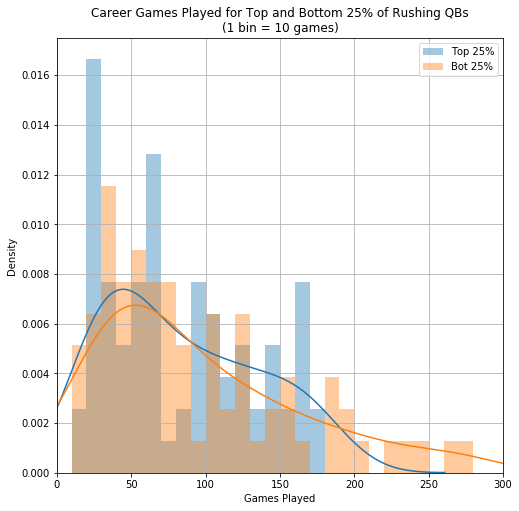

In [18]:
plt.figure(figsize = (8, 8))
gp_top25_max = int(ypa_top25['games_played'].max())
gp_bot25_max = int(ypa_bot25['games_played'].max())
sns.distplot(ypa_top25['games_played'],
             [i for i in range(0, gp_top25_max, 10)],
             label = 'Top 25%')
sns.distplot(ypa_bot25['games_played'],
             [i for i in range(0, gp_bot25_max, 10)],
             label = 'Bot 25%')
plt.xlim(0, 300)
plt.xlabel('Games Played')
plt.ylabel('Density')
plt.title('Career Games Played for Top and Bottom 25% of Rushing QBs' + \
          '\n(1 bin = 10 games)')
plt.grid(which = 'major')
plt.legend()
plt.show()

# Linear Regression Analysis

## Pair Plots

Below is a set of scatter plots which compares each quantitative variable against one another (also known as pair plots). When working with multiple variables, as is the case here, this is a great way to see what kind of relationships there may be between variables.

<Figure size 576x576 with 0 Axes>

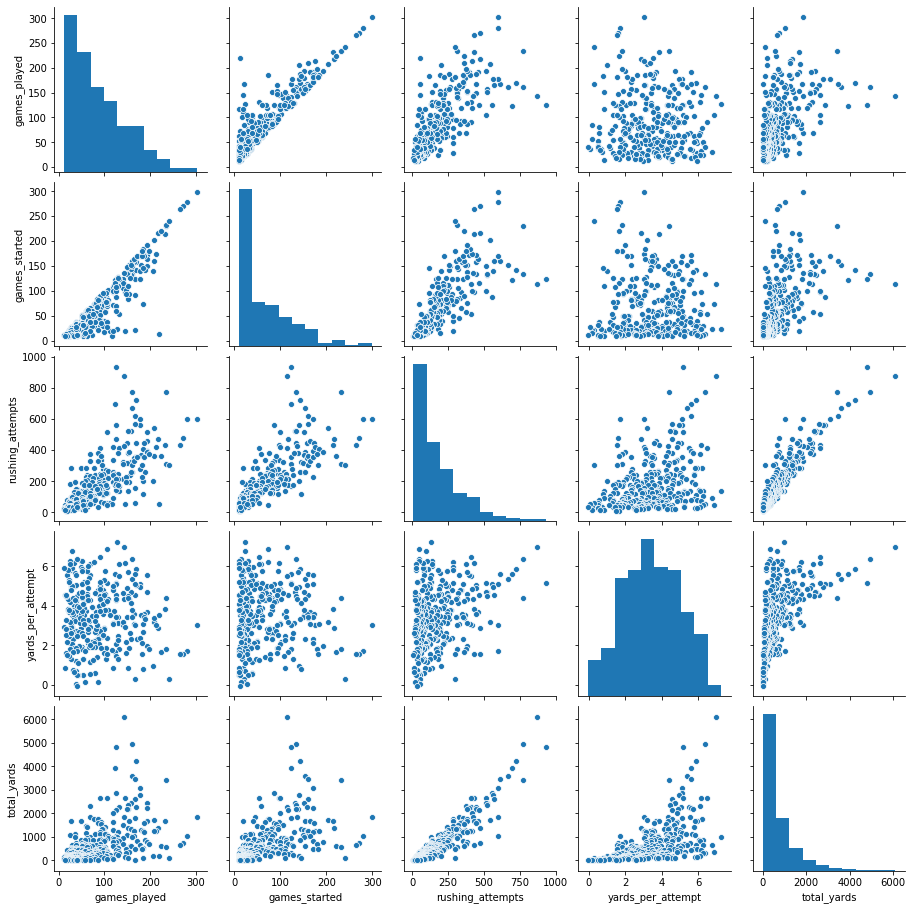

In [19]:
plt.figure(figsize = (8, 8))
fig = sns.pairplot(df[categories])
plt.show()

There is a very clear relationship between rushing attempts and total yards, as was to be expected. Given more opportunities to run, one should expect to gain more career yards. There is not a very clear relationship between games played and total yards (although there does appear to be some correlation), but it does look like there is a relationship between games played and rushing attempts.

## Plot Games Played as Function of Rushing Attempts & Total Yards

In the scatter plot below, I plot the three variables I am interested in: rushing attempts on the x-axis, total yards on the y-axis, and marker size representing the number of games played (larger markers = more games). Again, more games played provides more opportunities to rush and therefore the possiblity to gain more yards, so it makes sense that there is an increase in marker size as the plot moves up and to the right. What is extremely interesting, though, is that it looks as though the larger markers (more games) represent more of the lower portion of the scatter plot. This shows that for quarterbacks who rush a comparable number of times, those that are better at rushing (i.e. gain more yards on average) have shorter careers.

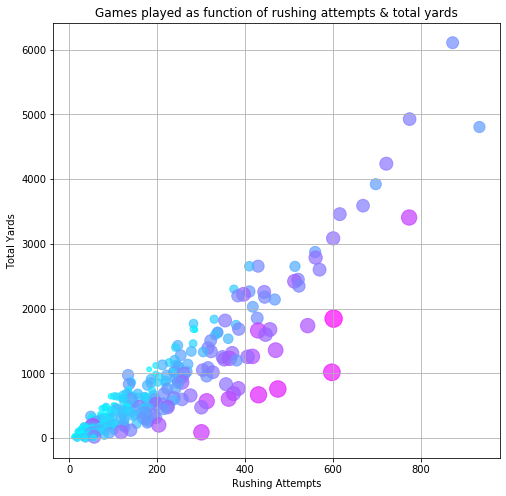

In [20]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(df['rushing_attempts'],
           df['total_yards'],
           s = df['games_played'],
           c = df['games_played'],
           cmap = mpl.cm.cool,
           alpha = 0.7)
ax.grid()
ax.set_xlabel('Rushing Attempts')
ax.set_ylabel('Total Yards')
ax.set_title('Games played as function of rushing attempts & ' \
             'total yards')
plt.show()

## Linear Regression Analysis Class

The class below represents a full linear regression model. When instantiated the first time, I simply feed in the dataframe with the target (`games_played`) and my two regressor variables (`rushing_attempts`, `total_yards`). When I run through the analysis a second time, I will feed in a group of outliers identified in the analysis to see what impact they have on the model.

In [32]:
class Analysis:
    '''
    Class to run ordinary least squares (OLS) and associated analysis
    '''
    
    def __init__(self, df_in, drop_pts = None):
        '''
        Parameters
        ----------
        df_in : dataframe to perform OLS on
        drop_points : int or list-like, optional
            Point(s) to drop for analysis. The default is None.
    
        Returns
        -------
        Points to potentially drop, if drop_points == None.
    
        '''        
        self.drop_points = drop_pts
        self.df = df_in.reset_index(drop = True)
        if self.drop_points:
            self.df = self.df.drop(self.drop_points).reset_index(drop = True)
        self.y, self.X = patsy.dmatrices('games_played ~ \
                                         rushing_attempts + total_yards',
                                         self.df)

    def lin_mod(self):
        '''
        Returns
        -------
        results : results class - use "dir(results)" to see available data

        '''
        self.model = sm.OLS(self.y, self.X)
        self.results = self.model.fit()
        self.results.model.data.design_info = self.X.design_info
        self.coefs = np.round(self.results.params, 3)
        print(self.results.summary())
        title_print('Model')
        print('y = {} + {} * rushing_attempts + {} * total_yards'.\
              format(self.coefs[0], self.coefs[1], self.coefs[2]))
        return self.results
    
    def significance(self):
        '''
        Returns
        -------
        None. Print R-squared

        '''
        title_print('Significance')
        if self.drop_points:
            print('Points dropped: {}'.format(sorted(self.drop_points)))
            print('Coefficients: {}'.format(np.round(self.results.params, 3)))
            print('R-squared: {}'.format(round(self.results.rsquared, 3)))
            return
        else:
            print('Coefficients: {}'.format(np.round(self.results.params, 3)))
            print('R-squared: {}'.format(round(self.results.rsquared, 3)))
    
    def anova(self):
        '''         
        Returns
        -------
        None. Prints ANOVA table

        '''
        # H0: beta_0 = beta_1 = beta_2
        # H1: beta_j != 0
        aov_table = sm.stats.anova_lm(self.results, typ = 1)
        title_print('Analysis of Variance table')
        print(aov_table)
        print('\nCalculated F-stat: {}'.
              format(round(f.ppf(0.025, self.X.shape[1] - 1, self.X.shape[0]),
                           3)))
        print('Regression F: {}'.format(round(self.results.fvalue, 2)))
        print('Regression p: {}'.format(round(self.results.f_pvalue, 4)))
        print('---> Regression is significant <---')
    
    def confidence_interval(self, a = 0.05):
        '''
        Parameters
        ----------
        a: float, alpha for confidence interval. Default: 0.05
            Note: use alpha of 0.05 for 95% confidence interval, for example
        
        Returns
        -------
        None. Calculates and prints confidence intervals

        '''
        conf_int = np.round(self.results.conf_int(a), 3)
        title_print('95% Confidence Intervals')
        print('Intercept: {} to {}'.format(conf_int[0][0], conf_int[0][1]))
        print('Rushing Attempts: {} to {}'.format(conf_int[1][0],
                                                  conf_int[1][1]))
        print('Total yards: {} to {}'.format(conf_int[2][0], conf_int[2][1]))

    def multicollinearity(self):
        '''
        Returns
        -------
        None. Calculates and prints variance inflation factor for parameters

        '''
        vif = np.round([variance_inflation_factor(self.X, i)
                        for i in range(self.X.shape[1])], 4)
        title_print('Multicollinearity')
        [print('VIF_{}: {}'.format(i, vif[i])) for i, v in enumerate(vif)]

    def residuals(self):
        '''
        Returns
        -------
        None. Calculates residuals. Plots residuals vs. fitted values and
              normality plots.

        '''
        self.resid = self.results.resid
        Prob = [(i - 1/2) / len(self.y) for i in range(len(self.y))]
        
        # Plot residuals vs. fitted values
        fig, ax = plt.subplots(figsize = (8, 8))
        ax.scatter(self.results.fittedvalues, self.resid)
        ax.axhline(0)
        ax.set_xlabel('Fitted Values')
        ax.set_ylabel('Residuals')
        plt.title('Residuals Versus Predicted Response')
        plt.show()
        
        # Calculate OLS from resid to plot straight line. y values from model
        resid_results = sm.OLS(Prob, sm.add_constant(sorted(self.resid))).fit()
        X_range = np.linspace(min(self.resid),
                              max(self.resid),
                              len(self.resid))
        
        # Normality plot
        fig = plt.figure(figsize = (8, 8))
        plt.scatter(sorted(self.resid), Prob)
        plt.plot(X_range,
                 resid_results.params[0] + resid_results.params[1] * X_range)
        plt.xlabel('Residual')
        plt.ylabel('Probability')
        plt.title('Normal Probability Plot')
        plt.show()
        print('---> Heavy-tailed distribution <---')
    
    def outliers(self):
        '''
        Find outliers and influential points based on:
              -leverage points (hat diagonal)
              -Cook's D
              -DFFITS
              -DFBETAS
              -COVRATIO
        Also prints points that appear in all tests
        
        Returns
        -------
        list : Points that appear in all tests
        
        '''
        title_print('Outliers / Influence Points')
        pos_out = (np.argmax(self.resid), np.amax(self.resid))
        neg_out = (np.argmax(-self.resid), -np.amax(-self.resid))
        x_out = (np.argmax(self.results.fittedvalues),
                 np.amax(self.results.fittedvalues))
        # Visually from residual plot, these 3 points are outliers
        
        # Influential points
        infl = self.results.get_influence()
        infl_df = infl.summary_frame()
        print(infl_df.head())
        print('...continued...')
        infl_pts = {}
        
        # Leverage Points - Hat Diagonal
        n, p = self.X.shape[0], self.X.shape[1] - 1
        lev_pt = 2 * p / n
        dhat_pts = list(infl_df[infl_df['hat_diag'] > lev_pt].index)
        print('\n***| Hat Diagonal |***')
        print('Leverage cutoff (2 * p \ n) = {}'.format(round(lev_pt, 3)))
        print('Points where hat diagonal exceeds leverage cutoff: {}'.
            format(dhat_pts))
        
        # Cook's D
        cook_pts = list(infl_df[infl_df['cooks_d'] > 1].index)
        print('\n***| Cook\'s D |***')
        print('Points where Cook\'s D is > 1: {}'.
          format(cook_pts))
        
        # DFFITS
        DFFITS_cutoff = 2 * np.sqrt(p / n)
        DFFITS_pts = list(infl_df[infl_df['dffits'] > DFFITS_cutoff].index)
        print('\n***| DFFITS |***')
        print('DFFITS cutoff (2 * sqrt(p / n)) = {}'.
              format(round(DFFITS_cutoff, 3)))
        print('Points which exceed DFFITS cutoff: {}'.
              format(DFFITS_pts))
        
        # DFBETAS
        print('\n***| DFBETAS |***')
        DFBETAS_cutoff = 2 / np.sqrt(n)
        DFBETAS_pts = []
        print('DFBETAS cutoff (2 / sqrt(n)) = {}'.
              format(round(DFBETAS_cutoff, 3)))
        for col in infl_df.columns:
            if 'dfb' in col:
                temp_dfbeta = list(infl_df[infl_df[col] > DFBETAS_cutoff].index)
                DFBETAS_pts.extend(temp_dfbeta)        
                print('Points which exceed DFBETAS cutoff for {}: {}'.
                      format(col,
                             list(temp_dfbeta)))
        
        # COVRATIO
        print('\n***| COVRATIO |***')
        COVRATIO_cutoff_pos = 1 + 3 * p / n
        COVRATIO_cutoff_neg = 1 - 3 * p / n
        gt_cutoff = list(compress(range(len(infl.cov_ratio)),
                                  infl.cov_ratio > COVRATIO_cutoff_pos))
        lt_cutoff = list(compress(range(len(infl.cov_ratio)),
                                  infl.cov_ratio < COVRATIO_cutoff_neg))
        COVRATIO_pts = gt_cutoff + lt_cutoff
        print('Upper COVRATIO cutoff (1 + 3 * p / n) = {}'.
              format(np.round(COVRATIO_cutoff_pos, 3)))
        print('Lower COVRATIO cutoff (1 - 3 * p / n) = {}'.
              format(np.round(COVRATIO_cutoff_neg, 3)))
        print('Points which are greater than COVRATIO upper bound cutoff:\n{}'.
              format(gt_cutoff))
        print('Points which are less than COVRATIO lower bound cutoff:\n{}'.
              format(lt_cutoff))
        
        # Most influential points
        for i in dhat_pts + cook_pts + DFFITS_pts + DFBETAS_pts + COVRATIO_pts:
            infl_pts[i] = infl_pts.get(i, 0) + 1
        most_infl = [pt for pt in infl_pts
                     if infl_pts[pt] == max(infl_pts.values())]
        print('\n***| MOST INFLUENTIAL POINTS |***') #points in every cutoff
        print(sorted(most_infl))
        
        # Check who these points are
        return most_infl

### Linear Regression Analysis - Run 1

Below, I instantiate the model with all of the data points and print out the results from the ordinary least squares linear regression.

Additionally, I will test the following hypothesis for rushing attempts:
$$H_0: \beta_1 = 0$$
$$H_1: \beta_1 \neq 0$$

and the following hypothesis for total yards:
$$H_0: \beta_2 = 0$$
$$H_1: \beta_2 \neq 0$$

In [22]:
run_1 = Analysis(df)
results_1 = run_1.lin_mod()

                            OLS Regression Results                            
Dep. Variable:           games_played   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     471.8
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           9.56e-96
Time:                        14:47:29   Log-Likelihood:                -1538.9
No. Observations:                 320   AIC:                             3084.
Df Residuals:                     317   BIC:                             3095.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           26.9561      2.610  

In [43]:
print('Calculated t-value = {}'.format(round(-t.ppf(0.025, len(df) - 2), 3)))

Calculated t-value = 1.967


The R-squared value of 0.749 is not incredibly convincing, but does show the model describes a significant portion of the data. The t-values associated with each coefficient are all much larger than the calculated t-value, allowing us to reject the null hypothesis in both instances. This means there is a linear relationship between the regressors and the dependent variable.

### Significance of Regression

In [23]:
run_1.significance()


################
| Significance |
################
Coefficients: [26.956  0.65  -0.081]
R-squared: 0.749


The 0.65 coefficient on the rushing attempts variable suggests that a quarterback only runs approximately 0.65 times per game, while the negative coefficient for total yards suggests that there is a very slight negative influence on the number of games played when a quarterback accumulates more yards.

### Analysis of Variance

In [24]:
run_1.anova()


##############################
| Analysis of Variance table |
##############################
                     df         sum_sq        mean_sq           F  \
rushing_attempts    1.0  592729.675536  592729.675536  667.128279   
total_yards         1.0  245574.769361  245574.769361  276.398972   
Residual          317.0  281647.942603     888.479314         NaN   

                        PR(>F)  
rushing_attempts  5.675987e-80  
total_yards       4.548333e-45  
Residual                   NaN  

Calculated F-stat: 0.025
Regression F: 471.76
Regression p: 0.0
---> Regression is significant <---


The F-statistics from the regression model are significantly higher than the calculated F-statistic (0.025) and the p-value is extremely small, which shows that rushing attempts and total yards are both significant regressors in this regression model.

### Confidence Intervals

In [25]:
run_1.confidence_interval()


############################
| 95% Confidence Intervals |
############################
Intercept: 21.82 to 32.092
Rushing Attempts: 0.6 to 0.701
Total yards: -0.091 to -0.071


These values represent the 95% confidence intervals for the coefficients of the regression model. That is, we can be 95% confident that the true values of the coefficients fall within this range for each of the respective coefficients, and conclude that the number of rushing attempts does in fact positively influence the model while the total yards has a slight negative impact.

### Multicollinearity

In [26]:
run_1.multicollinearity()


#####################
| Multicollinearity |
#####################
VIF_0: 2.454
VIF_1: 6.4373
VIF_2: 6.4373


Multicollinearity in a model shows whether there is a (near-)linear dependence among the regressors in the model, which can affect the ability of the model to make predictions. The variance inflation factor (VIF) is a measure of multicollinearity within the regression model, where high values for VIF (generally greater than 10) imply a problem with multicollinearity. The VIF of 6.4373 for coefficient 1 (rushing attempts) and 2 (total yards) shows there is some multicollinearity among the coefficients, but not high enough to imply a problem with the model.

### Residual Analysis

The following two plots are measures of the residuals, that is, the difference between the predicted value and the actual value (ground truth) for every data point.

The first plot simply shows the residual as a function of the predicted response for every data point. Ideally, the plotted points would form a horizontal band around $y = 0$, implying constant variance in predicted values and therefore no issue with the model. However, there appears to be a slight downward trend to the right, suggesting there may be some issue with the predictions the model is making.

The second plot is a normal probability plot, and ideally would form a linear plot. One of the assumptions for a linear regression analysis is that the prediction errors are normally distributed. By plotting the residuals in order of smallest to largest against the cumulative probability $P_i = \frac{(i - \frac{1}{2})}{n}$, we should expect an approximate straight line. While the central portion of the graph does follow a linear path and is overall more important than the extremes, the flattening towards either end show a deviation from the assumption that errors in prediction are normally distributed.

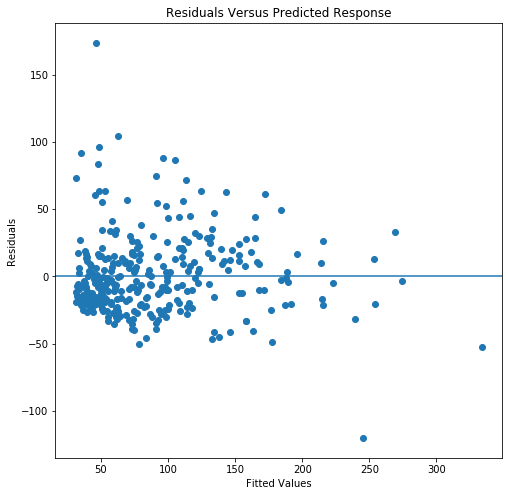

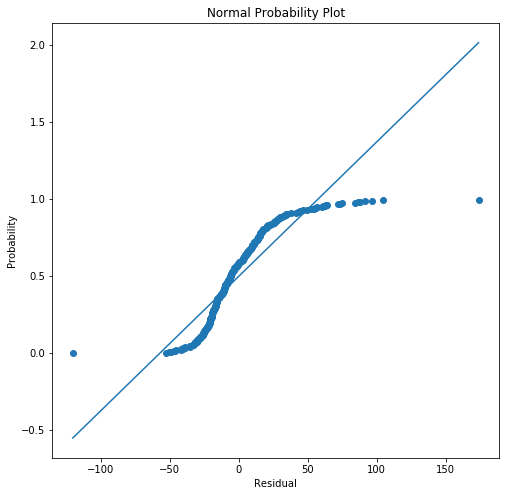

---> Heavy-tailed distribution <---


In [27]:
run_1.residuals()

### Leverage and Influence Points

The final analysis of the model looks at leverage and influence points, which by definition have unusual x or y values (or both) and therefore have a strong influence on the model. By identifying these outliers and removing them, we may be able to generate a more accurate model for prediction. It is important to note that removal of these outliers (or not) depends largely on subject matter expertise, as they may actually carry significant information about the data or model.

I look at 5 different measures for outliers:
1. Leverage points based on the diagonal elements of the hat matrix
2. Cook's D
3. DFFITS (number of standard deviations a predicated value would change if a data point is removed)
4. DFBETAS (measure of how each coefficient changes if a data point is removed)
5. COVRATIO (ratio which uses the determinant of the covariance matrix with a data point removed)

Each test uses different measures and cutoffs to test for outliers, so I ultimately focus on data points which fall into every outlier measure, *except* for Cook's D which did not identify any influential data points.

In [28]:
drop_pts_1 = run_1.outliers()


###############################
| Outliers / Influence Points |
###############################
   dfb_Intercept  dfb_rushing_attempts  dfb_total_yards   cooks_d  \
0      -0.047940             -0.381257         0.589320  0.173289   
1      -0.041966             -0.134464         0.238613  0.035625   
2       0.539282             -0.133052        -0.340553  0.460913   
3      -0.026860             -0.037607         0.084878  0.006249   
4       0.073524              0.056261        -0.166894  0.031530   

   standard_resid  hat_diag  dffits_internal  student_resid    dffits  
0        1.587280  0.171047         0.721017       1.591109  0.722757  
1        1.026830  0.092034         0.326917       1.026918  0.326945  
2       -4.185386  0.073160        -1.175900      -4.299256 -1.207892  
3        0.547539  0.058850         0.136917       0.546934  0.136766  
4       -1.382694  0.047144        -0.307556      -1.384693 -0.308001  
...continued...

***| Hat Diagonal |***
Leverage cutoff 

### First set of outliers

Below I look at the outliers (i.e. most influential points) generated from the list above. Most of these "outlier" names come as no surprise for anyone who has watched football in the last 20-30 years, whether it is because of their incredible rushing ability or complete lack thereof. For example, Michael Vick wracked up an average of 7 yards per rushing attempt (and is one of only two quarterbacks to have 1000+ rushing yards in one season), or Dan Marino who played for 17 years but only accumulated 87 career yards! Note that Michael Vick ran for more yards in a single game than Dan Marino ran in his entire 17 season career.

player               Michael Vick
games_played                  143
rushing_attempts              873
total_yards                  6109
yards_per_attempt               7
Name: 0, dtype: object

player               Randall Cunningham
games_played                        161
rushing_attempts                    775
total_yards                        4928
yards_per_attempt                  6.36
Name: 1, dtype: object

player               Ken Anderson
games_played                  192
rushing_attempts              397
total_yards                  2220
yards_per_attempt            5.59
Name: 26, dtype: object

player               Brett Favre
games_played                 302
rushing_attempts             602
total_yards                 1844
yards_per_attempt           3.06
Name: 33, dtype: object

player               Tom Brady
games_played               281
rushing_attempts           598
total_yards               1015
yards_per_attempt          1.7
Name: 101, dtype: object

player          

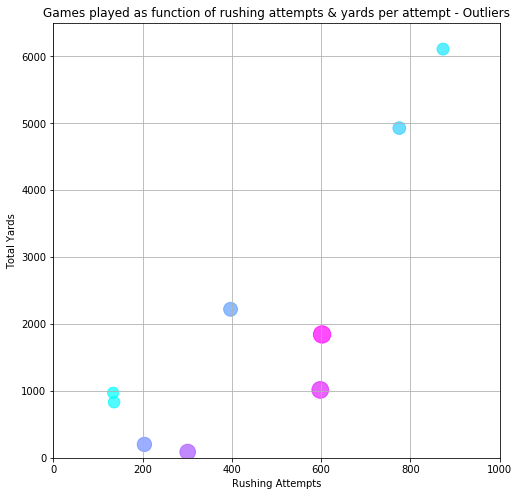

In [45]:
outlier_df = pd.DataFrame(columns = ['player',
                                     'games_played',
                                     'rushing_attempts',
                                     'total_yards',
                                     'yards_per_attempt'])
for i in drop_pts_1:
    player_info = df.iloc[i][['player',
                              'games_played',
                              'rushing_attempts',
                              'total_yards',
                              'yards_per_attempt']]
    outlier_df = outlier_df.append(player_info)
    print(player_info)
    print()

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(outlier_df['rushing_attempts'],
           outlier_df['total_yards'],
           s = outlier_df['games_played'],
           c = outlier_df['games_played'],
           cmap = mpl.cm.cool,
           alpha = 0.7)
ax.grid()
ax.set_xlim(0, 1000)
ax.set_ylim(0, 6500)
ax.set_xlabel('Rushing Attempts')
ax.set_ylabel('Total Yards')
ax.set_title('Games played as function of rushing attempts & ' \
             'yards per attempt - Outliers')
plt.show()

Very similar to the previous 3-variable scatter plot, players with lower total yards and rushing attempts played more games in general (marker size indicates number of games played).

### Linear Regression Analysis - Run 2

I will now rerun the entire linear regression analysis from beginning to end, having dropped the above mentioned outliers. I will generate another list of outliers to see who else might fall outside the normal ranges, but will not perform any further analysis after.

                            OLS Regression Results                            
Dep. Variable:           games_played   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     459.4
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           3.68e-93
Time:                        14:47:31   Log-Likelihood:                -1477.9
No. Observations:                 311   AIC:                             2962.
Df Residuals:                     308   BIC:                             2973.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           25.6577      2.534  

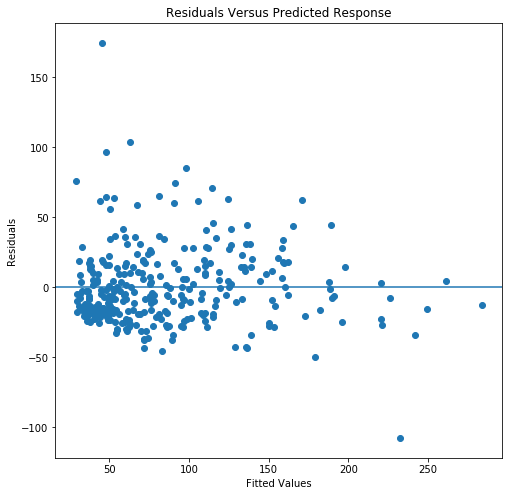

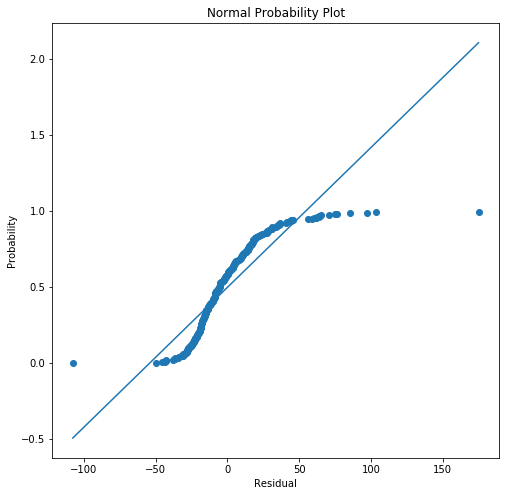

---> Heavy-tailed distribution <---

###############################
| Outliers / Influence Points |
###############################
   dfb_Intercept  dfb_rushing_attempts  dfb_total_yards   cooks_d  \
0       0.546731              0.026158        -0.494734  0.549030   
1      -0.054070             -0.134903         0.237527  0.039067   
2       0.053771              0.081574        -0.165023  0.023346   
3      -0.000935             -0.000762         0.001989  0.000005   
4      -0.040733             -0.086336         0.165364  0.022077   

   standard_resid  hat_diag  dffits_internal  student_resid    dffits  
0       -4.012842  0.092794        -1.283390      -4.115346 -1.316173  
1        1.140717  0.082627         0.342347       1.141277  0.342515  
2       -1.007082  0.064595        -0.264644      -1.007105 -0.264651  
3        0.016278  0.049792         0.003726       0.016251  0.003720  
4        1.129783  0.049329         0.257354       1.130291  0.257470  
...continued...

***

In [30]:
run_2 = Analysis(df, drop_pts_1)
results_2 = run_2.lin_mod()
run_2.significance()
run_2.anova()
run_2.confidence_interval()
run_2.multicollinearity()
run_2.residuals()
drop_pts_2 = run_2.outliers()

Removing the initial set of outliers from the dataset barely had any impact on the model: the R-squared value of 0.749 did not change at all, and the regression coefficients had extremely minor fluctuations. It looks as though this is the best model that can be generated for this dataset. Just for fun, I also look at the second set of outliers left over after the initial set has been removed below.

### Second set of outliers

In [31]:
df_2 = df.drop(drop_pts_2).reset_index(drop = True)
for i in drop_pts_2:
    print(df_2.iloc[i][['player', 'games_played', 'rushing_attempts',
                      'total_yards', 'yards_per_attempt']])
    print()

player               Cam Newton
games_played                125
rushing_attempts            934
total_yards                4806
yards_per_attempt          5.15
Name: 1, dtype: object

player               Donovan McNabb
games_played                    167
rushing_attempts                616
total_yards                    3459
yards_per_attempt              5.62
Name: 4, dtype: object

player               Daunte Culpepper
games_played                      105
rushing_attempts                  514
total_yards                      2652
yards_per_attempt                5.16
Name: 10, dtype: object

player               Robert Griffin
games_played                     49
rushing_attempts                283
total_yards                    1684
yards_per_attempt              5.95
Name: 28, dtype: object

player               Doug Flutie
games_played                  92
rushing_attempts             338
total_yards                 1634
yards_per_attempt           4.83
Name: 33, dtype: object

pl

### Conclusion

Based on this analysis, in general, quarterbacks who rush more have shorter careers. By looking at every quarterback who has played (and started more than 10 games) in the league since the first Super Bowl, I draw a very clear picture of what an "average" quarterback looks like in terms of rushing capabilities. I then do a linear regression analysis on those quarterbacks to understand the number of games played as a function of total yards rushed and rushing attempts. It is important to remember that more games played equates to more opportunities for rushing and therefore more opportunitities to accumulate total yards, so I should expect quarterbacks who play more years to have more yards in general. It is therefore very interesting to note that, in general, quarterbacks who did in fact play more games accumulated less yards and less rushing attempts, suggesting **consistently rushing as a quarterback will likely lead to a shorter career.**

# References

- Montgomery, Douglas C., et al. *Introduction to Linear Regression Analysis*. 4th ed., Wiley-Blackwell, 2006.
- “The Football Database.” *FootballDB.com*, www.footballdb.com/.